## Prep work

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression

In [2]:
data_dir = '../trimmedData'

In [4]:
years = ['00', '02', '04', '06', '08', '10', '12', '14', '16']

In [5]:
# PAC dataframe list
pdfl = []
# Individual dataframe list
idfl = []
for year in years:
    df = pd.read_csv(os.path.join(data_dir, '20{}p.csv'.format(year)))
    df['year'] = int('20' + year)
    pdfl.append(df)
    df = pd.read_csv(os.path.join(data_dir, '20{}i.csv'.format(year)))
    df['year'] = int('20' + year)
    idfl.append(df)
pdf = pd.concat(pdfl)
idf = pd.concat(idfl)
    

In [7]:
print(pdf.dtypes)
print(idf.dtypes)

CID       object
amount     int64
year       int64
dtype: object
CID        object
amount    float64
year        int64
dtype: object


## Calculate and Visualize total contributions

In [8]:
total_df = pd.concat([df, idf])
total_df.head()

,CID,amount,year
0,,1956547.0,2016
1,C00000059,3114.0,2016
2,C00000422,59031.0,2016
3,C00000638,11596.0,2016
4,C00000729,30655.0,2016


In [9]:
pac_cycle_total = pdf.groupby('year').sum()
ind_cycle_total = idf.groupby('year').sum()
cycle_total = total_df.groupby('year').sum()

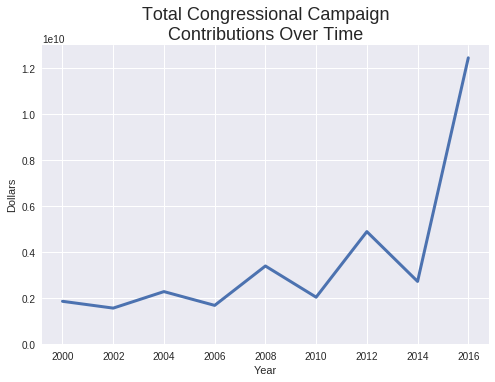

In [10]:
plt.style.use('seaborn')
plt.plot(cycle_total, lw=3)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.title("Total Congressional Campaign\nContributions Over Time", size=18)
plt.ylim([0, 1.3e10])
plt.xlabel("Year")
plt.ylabel("Dollars")
plt.savefig("q1-TotalContributions.png")

## Calculate total contributions per year per candidate; visualize distributions

In [11]:
years = [2004, 2006, 2008, 2012, 2014, 2016]
distributions = []
for year in years:
    distributions.append(total_df[total_df['year'] == year].groupby('CID')['amount'].sum())

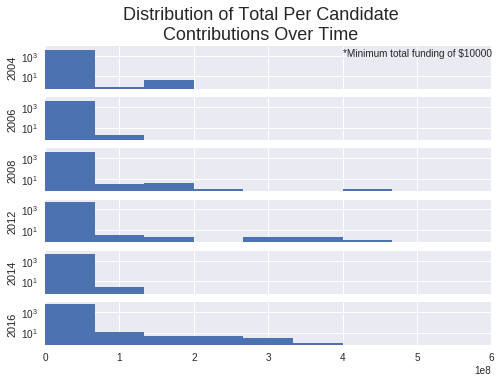

In [12]:
fig, axs = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True)
plt.suptitle("Distribution of Total Per Candidate\nContributions Over Time", size=18)
for year, dist, ax in zip(years, distributions, axs):
    ax.hist([i for i in dist if (i > 10000 and i < 6e8)], bins=np.linspace(start=0, stop=6e8, num=10))
    ax.set_yscale('log', nonposy='clip')
    ax.set_xlim([0, 6e8])
    ax.set_ylabel(year)
axs[0].annotate(xy=(400000000,1000), s="*Minimum total funding of $10000")
plt.savefig("q1-DistributionOfCandidateTotals.png")

## Calculate and Visualize the breakdown (individuals vs pacs)

In [13]:
ppl = []
ipl = []
for p, i, y in zip(pac_cycle_total['amount'], ind_cycle_total['amount'], years):
    total = p + i
    pp = p / total
    ip = i / total
    ppl.append(pp)
    ipl.append(ip)

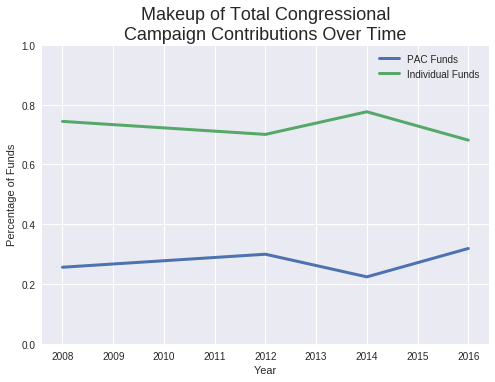

In [19]:
plt.plot(years[-4:], ppl[-4:], label="PAC Funds", lw=3)
plt.plot(years[-4:], ipl[-4:], label="Individual Funds", lw=3)
plt.title("Makeup of Total Congressional\nCampaign Contributions Over Time", size=18)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Percentage of Funds")
plt.ylim([0, 1])
plt.savefig("q1-MakeupOfTotalContributions.png")

## Predicting

In [49]:
ind_cycle_total['year'] = ind_cycle_total.index
ind_cycle_total = ind_cycle_total.rename({'amount': 'i'}, axis=1)
pac_cycle_total['year'] = pac_cycle_total.index
pac_cycle_total = pac_cycle_total.rename({'amount': 'p'}, axis=1)

In [41]:
df = ind_cycle_total.merge(pac_cycle_total, how='outer', on='year')
df['pres'] = df['year'].apply(lambda x: x % 4 == 0)
df

,i,year,p,pres
0,1.847893e+09,2000,392374167,True
1,1.551674e+09,2002,368815035,False
2,2.269808e+09,2004,781351944,True
3,1.670380e+09,2006,714569399,False
4,3.382997e+09,2008,976108406,True
5,2.026438e+09,2010,948693263,False
6,4.877278e+09,2012,1844396117,True
7,2.712081e+09,2014,1226627652,False
8,6.217897e+09,2016,1962258078,True


In [47]:
train = df.iloc[:6]
test = df.iloc[6:]
print(train)
print(test)

              i  year          p   pres
0  1.847893e+09  2000  392374167   True
1  1.551674e+09  2002  368815035  False
2  2.269808e+09  2004  781351944   True
3  1.670380e+09  2006  714569399  False
4  3.382997e+09  2008  976108406   True
5  2.026438e+09  2010  948693263  False
              i  year           p   pres
6  4.877278e+09  2012  1844396117   True
7  2.712081e+09  2014  1226627652  False
8  6.217897e+09  2016  1962258078   True


## Modeling Individuals

In [72]:
model = LinearRegression()
model.fit(train[['year', 'pres']], train['i'])
predictions = model.predict(df[['year', 'pres']])

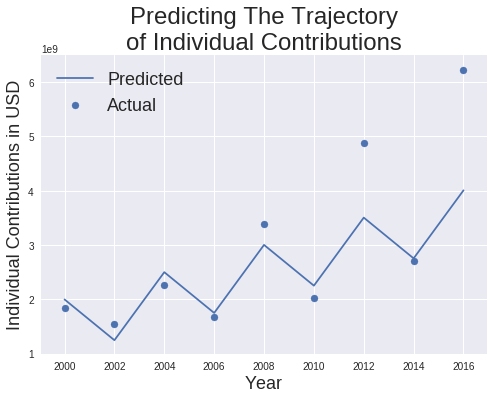

In [73]:
plt.plot(df['year'], predictions, label="Predicted")
plt.scatter(df['year'], df['i'], label="Actual")
plt.title("Predicting The Trajectory\nof Individual Contributions", size=24)
plt.legend(fontsize=18)
plt.ylabel("Individual Contributions in USD", size=18)
plt.xlabel("Year", size=18)
plt.show()

## Modeling PACs

In [74]:
model = LinearRegression()
model.fit(train[['year', 'pres']], train['p'])
predictions = model.predict(df[['year', 'pres']])

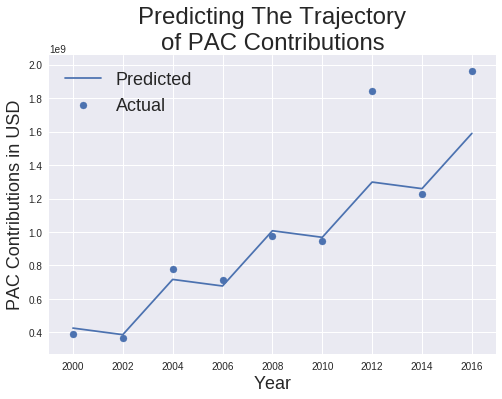

In [75]:
plt.plot(df['year'], predictions, label="Predicted")
plt.scatter(df['year'], df['p'], label="Actual")
plt.title("Predicting The Trajectory\nof PAC Contributions", size=24)
plt.legend(fontsize=18)
plt.ylabel("PAC Contributions in USD", size=18)
plt.xlabel("Year", size=18)
plt.show()